<a href="https://colab.research.google.com/github/BenjaAR/SEM11_ALGORITMOS/blob/main/SEMANA_11_ALGORITMOS_GEN%C3%89TICOS_Y_EVOLUCI%C3%93N_DE_LA_POBLACI%C3%93N_AQUINO_REYES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMANA 11: ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN

## Nombre: Aquino Reyes Benjy Alvaro


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Datos faltantes:
TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

         TV     Radio  Newspaper     Sales
0  0.969852  0.981522   1.778945  1.552053
1 -1.197376  1.082808   0.669579 -0.696046
2 -1.516155  1.528463   1.783549 -0.907406
3  0.052050  1.217855   1.286405  0.860330
4  0.394182 -0.841614   1.281802 -0.215683


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


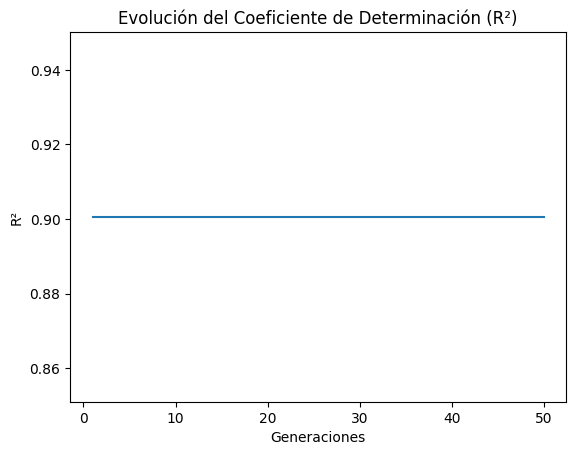

Mejor individuo: [1, 1, 0]


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from deap import base, creator, tools, algorithms
import random
from scipy import stats

# Cargar los datos
file_path = '/content/drive/MyDrive/Tecsup/5° Ciclo - 2025 - I/Minería de Datos/SEM11/Advertising-1.csv'
data = pd.read_csv(file_path)

# Preprocesamiento de los datos
# Análisis de datos faltantes
missing_data = data.isnull().sum()
print(f"Datos faltantes:\n{missing_data}\n")

# Imputar datos faltantes usando la media
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Tratamiento de outliers a nivel univariado (usamos el Z-score)
z_scores = np.abs(stats.zscore(data_imputed.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).all(axis=1)  # Filtrar registros con outliers en todas las columnas
data_no_outliers = data_imputed[~outliers]

# Escalamiento de las variables numéricas (StandardScaler)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_no_outliers.select_dtypes(include=[np.number])),
                           columns=data_no_outliers.select_dtypes(include=[np.number]).columns)

# Añadir las variables no numéricas al conjunto escalado
data_final = pd.concat([data_no_outliers.select_dtypes(exclude=[np.number]), data_scaled], axis=1)

# Visualizar los primeros datos procesados
print(data_final.head())

# Crear tipos básicos para el algoritmo genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Función para crear un individuo (subconjunto de variables)
def create_individual():
    return [random.randint(0, 1) for _ in range(data_final.shape[1] - 1)]  # Excluyendo la columna objetivo 'Sales'

# Función para evaluar la calidad de un individuo
def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,  # Penalizamos los individuos sin variables seleccionadas
    X = data_final.iloc[:, selected_features]
    y = data_final['Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenamiento del modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Cálculo de R2
    r2 = r2_score(y_test, y_pred)
    return r2,  # El valor debe estar dentro de una tupla

# Crear el conjunto de herramientas para el algoritmo genético
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Configuración de parámetros
population_size = 50
prob_crossover = 0.7
prob_mutation = 0.2
generations = 50

# Crear población inicial
population = toolbox.population(n=population_size)

# Listas para almacenar la evolución del R² en cada generación
r2_evolution = []

# Ejecutar el algoritmo genético
for gen in range(generations):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Aplicar cruce y mutación
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < prob_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < prob_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluar fitness de los individuos modificados
    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_individuals:
        ind.fitness.values = toolbox.evaluate(ind)

    # Reemplazar la población con la descendencia
    population[:] = offspring

    # Obtener el R² de la mejor solución de esta generación
    best_individual = tools.selBest(population, 1)[0]
    r2_evolution.append(best_individual.fitness.values[0])

# Graficar la evolución de R²
generations_range = range(1, generations + 1)
plt.plot(generations_range, r2_evolution)
plt.xlabel('Generaciones')
plt.ylabel('R²')
plt.title('Evolución del Coeficiente de Determinación (R²)')
plt.show()

# Mostrar el mejor individuo y su R²
best_individual = tools.selBest(population, 1)[0]
print(f"Mejor individuo: {best_individual}")


In [27]:
# Seleccionar las mejores variables según el algoritmo genético
best_selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

# Crear los datos de entrenamiento y prueba con las mejores variables
X_best = data_final.iloc[:, best_selected_features]
y_best = data_final['Sales']
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, random_state=42)

# Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Mostrar los coeficientes del modelo
coefficients = model.coef_
intercept = model.intercept_

# Mostrar los coeficientes con los nombres de las variables
feature_names = data_final.columns[best_selected_features]
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coefficients
})

print("\nCoeficientes del modelo de regresión lineal:")
print(coef_df)


Coeficientes del modelo de regresión lineal:
  Variable  Coeficiente
0       TV     0.736013
1    Radio     0.542563


In [28]:
# Mostrar la ecuación de la regresión
feature_names = data_final.columns[best_selected_features]
equation = "Sales = {:.4f}".format(intercept)

# Añadir los coeficientes para cada variable seleccionada
for name, coef in zip(feature_names, coefficients):
    equation += " + ({:.4f}) * {}".format(coef, name)

print("\nEcuación de la regresión lineal:")
print(equation)


Ecuación de la regresión lineal:
Sales = 0.0035 + (0.7360) * TV + (0.5426) * Radio
